# Counting objects workflow (batch)

---
*Introduction to Image Analysis Workshop*

*Stefania Marcotti (stefania.marcotti@crick.ac.uk)*

*Intro to building batch image analysis pipelines with Python*

*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

Following on from the previous [notebook](https://github.com/RMS-DAIM/introduction-to-image-analysis/tree/main/Scripts/Jupyter/counting_objects.ipynb), we run the same pipeline on all the images available in the [`Data/idr0028`](https://github.com/RMS-DAIM/introduction-to-image-analysis/tree/main/Data/idr0028) folder.

### Import libraries

Note we are importing also the library `os` (API [here](https://docs.python.org/3/library/os.html)) which provides miscellaneous operating system interfaces.

In [1]:
import os

import numpy as np

from skimage import io
from skimage import filters
from skimage import measure

import matplotlib.pyplot as plt

import pandas as pd

### Import data
This time we are reading all of the files in the folder - note the use of the wildcard `*`!

In [2]:
# get the list of all files and directories
path = '../../Data/idr0028/'
dir_list = os.listdir(path)

print(*dir_list, sep='\n')

003003-15.tif
003003-14.tif
003003-16.tif
003003-17.tif
003003-13.tif
003003-12.tif
003003-10.tif
003003-11.tif
003003-19.tif
003003-18.tif


In [3]:
# read all .tif files in folder
im_read = io.imread('../../Data/idr0028/*.tif')

In [4]:
# check the dimensions of the object
print('Object dimensions:', im_read.shape)

Object dimensions: (10, 501, 667, 4)


The image dimensions are currently in the (n, y, x, c) format. Ideally, by convention, we would want the dimensions of the image to be (n, c, x, y). We can rearrange the dimensions by using the numpy function `transpose`.

In [5]:
im_all = np.transpose(im_read, (0, 3, 1, 2))
print('New object dimensions:', im_all.shape)

New object dimensions: (10, 4, 501, 667)


We can visualise some example nuclear images by running the cell below. The variable `im_idx` indicates which image we want to open (first=1, second=2, ...)

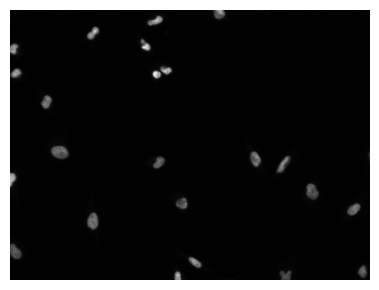

In [7]:
# select image
im_idx =6
im = im_all[im_idx,0,]

# display the chosen image
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(im, cmap='gray')
ax.axis('off')
plt.tight_layout()

### Perform the analysis on one image at the time
By using a `for` loop, we can open one image at the time, and perform the same exact pipeline as before to count the objects and measure their area and eccentricity. We can then append the results in a long list where each cell is an n=1 and plot the output.

In [10]:
for im_idx in range(im_all.shape[0]):
    print(im_idx)

0
1
2
3
4
5
6
7
8
9


In [11]:
# initialise output
obj_count = []
props_df = pd.DataFrame()

# set up for loop for all the images available in the folder
for im_idx in range(im_all.shape[0]):
    # open image (only ch0)
    im = im_all[im_idx,0,]
    # filter with Gaussian
    im_gauss = filters.gaussian(im, sigma=5)
    # threshold with Otsu
    thresh = filters.threshold_otsu(im_gauss)
    im_thresh = im_gauss >= thresh
    # label mask
    labels = measure.label(im_thresh)
    # count objects
    obj_count = np.append(obj_count,labels.max())
    # measure properties
    props = measure.regionprops_table(labels, im, properties=['area', 'eccentricity'])
    props = pd.DataFrame(props)
    # add image ID and object ID
    props['image_ID'] = dir_list[im_idx]
    props['object_ID'] = props.index+1
    # add to output dataframe
    props_df = pd.concat([props_df, pd.DataFrame(props)], ignore_index=True)

In [12]:
# print output [obj_count]
print('The number of nuclei for each image is:', obj_count)

The number of nuclei for each image is: [30. 31. 23.  9. 31. 20. 22. 22. 36. 21.]


In [13]:
for im_idx in range(im_all.shape[0]):
    print('The number of nuclei in', dir_list[im_idx], 'is', obj_count[im_idx])

The number of nuclei in 003003-15.tif is 30.0
The number of nuclei in 003003-14.tif is 31.0
The number of nuclei in 003003-16.tif is 23.0
The number of nuclei in 003003-17.tif is 9.0
The number of nuclei in 003003-13.tif is 31.0
The number of nuclei in 003003-12.tif is 20.0
The number of nuclei in 003003-10.tif is 22.0
The number of nuclei in 003003-11.tif is 22.0
The number of nuclei in 003003-19.tif is 36.0
The number of nuclei in 003003-18.tif is 21.0


In [15]:
# show the beginning of the properties dataframe
props_df.tail()

,area,eccentricity,image_ID,object_ID
240,1120.0,0.583851,003003-18.tif,17
241,441.0,0.463595,003003-18.tif,18
242,455.0,0.591247,003003-18.tif,19
243,812.0,0.931810,003003-18.tif,20
244,510.0,0.756785,003003-18.tif,21


In [16]:
# how many nuclei did we analyse?
print('We analysed', len(props_df), 'nuclei in', im_all.shape[0], 'images')

We analysed 245 nuclei in 10 images


### Plot some results

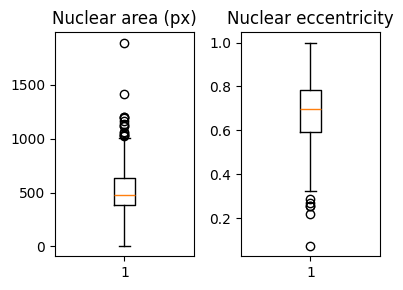

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(4,3))

axs[0].boxplot(props_df['area'])
axs[0].set_title('Nuclear area (px)')

axs[1].boxplot(props_df['eccentricity'])
axs[1].set_title('Nuclear eccentricity')

plt.tight_layout()

### Save outputs

In [18]:
# save dataframe as excel file
props_df.to_excel('../../Data/idr0028/results_jupyter.xlsx')

In [19]:
# save label images
for im_idx in range(im_all.shape[0]):
    # open image (only ch0)
    im = im_all[im_idx,0,]
    # filter with Gaussian
    im_gauss = filters.gaussian(im, sigma=5)
    # threshold with Otsu
    thresh = filters.threshold_otsu(im_gauss)
    im_thresh = im_gauss >= thresh
    # label mask
    labels = measure.label(im_thresh)
    # save
    file_name = '../../Data/idr0028/'+dir_list[im_idx][0:-4]+'_labels.tif'
    io.imsave(file_name, labels)

/opt/miniconda3/envs/introIA-env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ../../Data/idr0028/003003-15_labels.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/introIA-env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ../../Data/idr0028/003003-14_labels.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/introIA-env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ../../Data/idr0028/003003-16_labels.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/introIA-env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ../../Data/idr0028/003003-17_labels.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/introIA-env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: ../../Data/idr0028/003003-13_labels.tif is a low contrast image
  return func(*args, **kwargs)


### Visualise the data using `napari`

You might want to check the import options at [this `napari` API documentation page](https://napari.org/stable/api/napari.html#napari.view_image)

In [20]:
im_idx = 0
# open image (only ch0)
im = im_all[im_idx,0,]
# filter with Gaussian
im_gauss = filters.gaussian(im, sigma=5)
# threshold with Otsu
thresh = filters.threshold_otsu(im_gauss)
im_thresh = im_gauss >= thresh
# label mask
labels = measure.label(im_thresh)

In [21]:
import napari

In [22]:
viewer = napari.Viewer()
viewer.add_image(im_all[im_idx,0,], name='nuclei', colormap='cyan', blending='additive')
viewer.add_image(im_all[im_idx,1,], name='tubulin', colormap='magenta', blending='additive')
viewer.add_image(im_all[im_idx,2,], name='actin', colormap='green', blending='additive')
viewer.add_image(im_all[im_idx,3,], name='YAP/TAZ', colormap='yellow', blending='additive')

<Image layer 'YAP/TAZ' at 0x33b493fa0>

In [23]:
viewer = napari.Viewer()
viewer.add_image(im, name='nuclei', blending='additive')
viewer.add_image(im_gauss, name='nuclei_gauss', blending='additive')
viewer.add_labels(im_thresh, name='nuclei_thresh', blending='additive')
viewer.add_labels(labels, name='nuclei_label', blending='additive')

<Labels layer 'nuclei_label' at 0x3350af490>

### Further reading
If you're interested in knowing more about image analysis in Python, there are a lot of free resources out there! One good starting point is the [IAFIG-RMS Python for Bioimage Analysis Course](https://github.com/RMS-DAIM/Python-for-Bioimage-Analysis). Good luck with your image analysis adventures!